In [1]:
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
import bisect
import sys
from pickle import FALSE
from collections import OrderedDict
import neurokit2 as nk
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt



sys.path.append('..')  # Add the parent directory to the sys.path

import utils.dataset_loader as dataset_loader

! gpustat

chuck2                    Tue Jun 25 15:48:36 2024  535.183.01
[0] NVIDIA A100-SXM4-80GB | 30°C,   0 % |     0 / 81920 MB |
[1] NVIDIA A100-SXM4-80GB | 30°C,   0 % |     0 / 81920 MB |


In [2]:
true_r_peaks_indices = torch.tensor([64, 316, 568, 819, 1074, 1326, 1588, 1853, 2110, 2370, 2626, 2889, 3153, 3412, 3672, 3928, 4192, 4462, 4728])
ECG_R_Peaks_indices = torch.tensor([309, 562, 812, 1067, 1321, 1580, 1847, 2105, 2364, 2620, 2882, 3147, 3405, 3665, 3922, 4186, 4455, 4721])

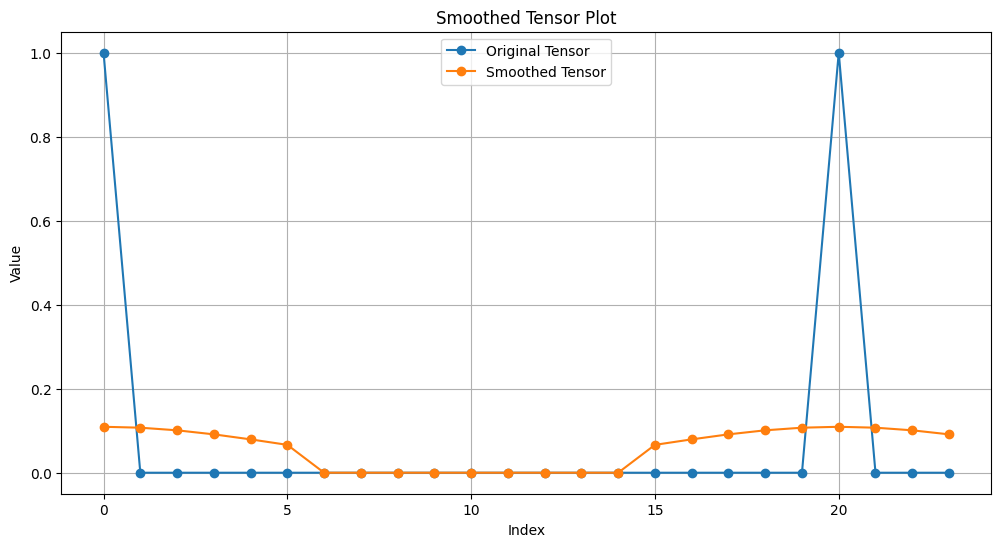

In [3]:
# true_indices = [64,  316,  568,  819, 1074]
# pred_indices = [ 309,  562,  812, 1067] #  , 1321]

# a = torch.zeros(max(true_indices)+1)
# a[true_indices] = 1
# Define the input tensor
y = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.float32)

# print(torch.where(a==1))
# print(len([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]))
# Convolve the input tensor with the Gaussian kernel
def smooth_tensor(input_tensor, kernel_size=3, sigma=1):
    # Check if the kernel size is odd and greater than zero
    if kernel_size % 2 == 0 or kernel_size <= 0:
        raise ValueError("Kernel size must be an odd number and greater than zero.")
    
    # Create a Gaussian kernel
    kernel_range = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1, dtype=torch.float32)
    kernel = torch.exp(-0.5 * (kernel_range / sigma)**2)
    kernel /= kernel.sum()

    # Pad input tensor with zeros - kernel_size // 2 at the beginning and end
    padded_tensor = F.pad(input_tensor, (kernel_size // 2, kernel_size // 2), mode='constant', value=0)

    # Perform convolution
    smoothed_tensor = F.conv1d(padded_tensor.view(1, 1, -1), kernel.view(1, 1, -1), padding=0).view(-1)
    
    return smoothed_tensor

# Apply smoothing
smooth_to_each_side = 5
a_smoothed = smooth_tensor(y, kernel_size=2*smooth_to_each_side+1, sigma=smooth_to_each_side)

def plot_tensor(input_tensor, smoothed_tensor):
    plt.figure(figsize=(12, 6))
    plt.plot(input_tensor, label='Original Tensor', marker='o')
    plt.plot(smoothed_tensor, label='Smoothed Tensor', marker='o')
    plt.title('Smoothed Tensor Plot')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot pnly the smoothed tensor
# plt.plot(range(len(a_smoothed)), a_smoothed, marker='o')

plot_tensor(y, a_smoothed)

a_indices = torch.nonzero(y).squeeze()
a_smoothed_indices = torch.nonzero(a_smoothed).squeeze()
# print(f"{a_indices=}\n{a_smoothed_indices=}")
# print(f"{a=}\n{a_smoothed=}")
# a_smoothed

In [4]:
# Given tensors
a_pred = torch.tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
                       0., 1., 0., 0., 0., 1.])

def modify_a_pred(a_smoothed, a_pred):
    intervals = []
    new_indices = []
    in_interval = False
    start = 0

    for i in range(len(a_smoothed)):
        if a_smoothed[i] > 0 and not in_interval:
            start = i
            in_interval = True
        elif a_smoothed[i] == 0 and in_interval:
            intervals.append((start, i))
            in_interval = False

    if in_interval:
        intervals.append((start, len(a_smoothed)))

    for start, end in intervals:
        ones_indices = (start + torch.nonzero(a_pred[start:end] == 1).squeeze()).tolist()

        if isinstance(ones_indices, int):
            ones_indices = [ones_indices]

        if len(ones_indices) > 1:
            max_index = ones_indices[a_smoothed[ones_indices].argmax()]
            new_indices.append(max_index)

    modified_a_pred = torch.zeros_like(a_pred)
    modified_a_pred[new_indices] = 1
    
    return modified_a_pred

modified_a_pred = modify_a_pred(a_smoothed, a_pred)
modified_a_pred_indices = torch.nonzero(modified_a_pred).squeeze().tolist()
a_indices = torch.nonzero(y).squeeze().tolist()
print(f"{modified_a_pred_indices=}\n{a_indices=}\n")

modified_a_pred_indices=[0, 19]
a_indices=[0, 20]



In [5]:
def smooth_batch(input_tensor, kernel_size=3, sigma=1):
    # Check if the kernel size is odd and greater than zero
    if kernel_size % 2 == 0 or kernel_size <= 0:
        raise ValueError("Kernel size must be an odd number and greater than zero.")
    
    # Create a Gaussian kernel
    kernel_range = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1, dtype=torch.float32)
    kernel = torch.exp(-0.5 * (kernel_range / sigma)**2)
    kernel /= kernel.sum()

    padded_tensor = F.pad(input_tensor, pad=(kernel_size // 2, kernel_size // 2), mode='constant', value=0)

    # Use F.conv1d instead of F.conv2d
    smoothed_tensor = F.conv1d(padded_tensor.unsqueeze(1), kernel.view(1, 1, -1), padding=0)

    return smoothed_tensor.squeeze(1)

a_batch = torch.tensor([
                     [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                       0., 0., 0., 0., 0., 1.],

                     [0, 0, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                       0., 0., 0., 0., 0., 0.]
                       ]
                    )


In [6]:
# Apply smoothing
smooth_to_each_side = 5
a_pred_batch_smooth = smooth_batch(a_batch, kernel_size=2*smooth_to_each_side+1, sigma=smooth_to_each_side)
print(f"{a_batch.shape=}\n{a_pred_batch_smooth.shape=}")

a_batch.shape=torch.Size([2, 24])
a_pred_batch_smooth.shape=torch.Size([2, 24])


In [7]:
def modify_a_pred_batch(a_smoothed_batch, a_pred_batch):
    batch_size = a_smoothed_batch.shape[0]
    modified_a_pred_batch = torch.zeros_like(a_pred_batch)

    for b in range(batch_size):
        a_smoothed = a_smoothed_batch[b]
        a_pred = a_pred_batch[b]
        intervals = []
        new_indices = []
        in_interval = False
        start = 0

        for i in range(len(a_smoothed)):
            if a_smoothed[i] > 0 and not in_interval:
                start = i
                in_interval = True
            elif a_smoothed[i] == 0 and in_interval:
                intervals.append((start, i))
                in_interval = False

        if in_interval:
            intervals.append((start, len(a_smoothed)))

        for start, end in intervals:
            ones_indices = (start + torch.nonzero(a_pred[start:end] == 1)).squeeze().tolist()

            if isinstance(ones_indices, int):
                # ones_indices = [ones_indices]
                new_indices.append(ones_indices)
                continue

            if len(ones_indices) > 1:
                max_index = ones_indices[a_smoothed[ones_indices].argmax()]
                new_indices.append(max_index)

        modified_a_pred_batch[b, new_indices] = 1

    return modified_a_pred_batch


In [8]:
a_pred_batch = torch.tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
                       0., 1., 0., 1., 0., 0.],
                       [0., 0, 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
                       0., 1., 0., 0., 0., 0.]]
                    )


In [9]:
def plot_tensor(input_tensor, smoothed_tensor):
    """
    other option: plt.plot(range(len(input_tensor)), input_tensor, marker='o')
    """
    plt.figure(figsize=(12, 6))
    plt.plot(input_tensor, label='Original Tensor', marker='o')
    plt.plot(smoothed_tensor, label='Smoothed Tensor', marker='o')
    plt.title('Smoothed Tensor Plot')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

a_pred_batch_smooth.shape=torch.Size([2, 24])
modified_a_pred_batch.shape=torch.Size([2, 24])


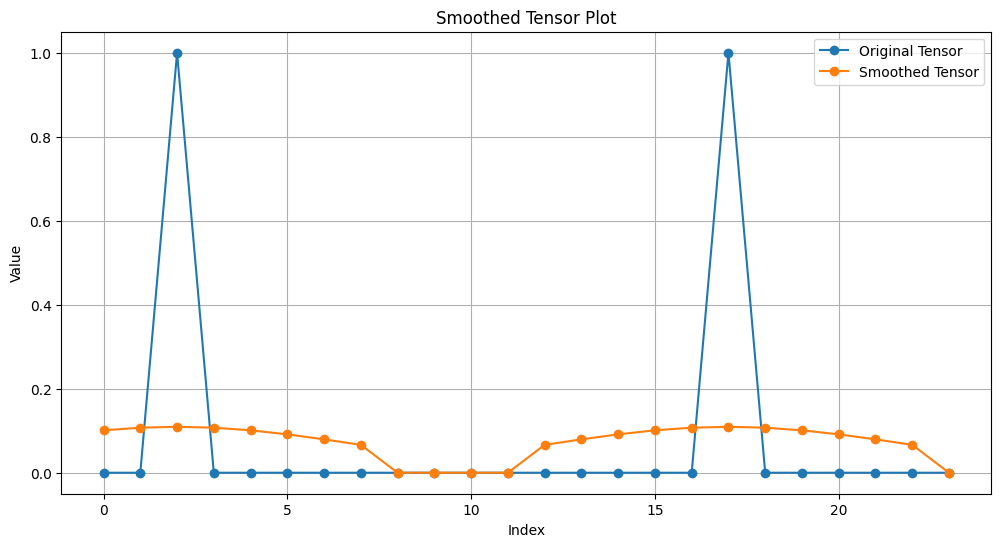

In [10]:
smooth_to_each_side = 6
a_batch_smooth = smooth_batch(a_batch, kernel_size=2*smooth_to_each_side+1, sigma=smooth_to_each_side)
# plt.plot(range(len(a_pred_batch_smooth[0])), a_pred_batch_smooth[0], marker='o')
modified_a_pred_batch = modify_a_pred_batch(a_batch_smooth, a_pred_batch)
print(f"{a_pred_batch_smooth.shape=}\n{modified_a_pred_batch.shape=}")
plot_tensor(a_batch[1], a_pred_batch_smooth[1])

In [11]:
a_batch_indices = [torch.nonzero(row == 1).squeeze(1) for row in a_batch]
modified_a_pred_batch_idices = [torch.nonzero(row == 1).squeeze(1) for row in modified_a_pred_batch]

print(f"{a_batch_indices=}\n{modified_a_pred_batch_idices=}")
for e1, e2 in zip(modified_a_pred_batch_idices, a_batch_indices):
    print(f"{e1=}, {e2=}")

a_batch_indices=[tensor([ 2, 23]), tensor([ 2, 17])]
modified_a_pred_batch_idices=[tensor([ 2, 21]), tensor([ 5, 16])]
e1=tensor([ 2, 21]), e2=tensor([ 2, 23])
e1=tensor([ 5, 16]), e2=tensor([ 2, 17])


In [14]:
true_r_peaks_indices = torch.tensor([64, 316, 568, 819, 1074, 1326, 1588, 1853, 2110, 2370, 2626, 2889, 3153, 3412, 3672, 3928, 4192, 4462, 4728])
ECG_R_Peaks_indices = torch.tensor([309, 562, 812, 1067, 1321, 1580, 1847, 2105, 2364, 2620, 2882, 3147, 3405, 3665, 3922, 4186, 4455, 4721])

tensor_len = max(max(true_r_peaks_indices), max(ECG_R_Peaks_indices)) +1

true_r_peaks = torch.zeros(tensor_len)
true_r_peaks[true_r_peaks_indices] = 1
true_r_peaks = true_r_peaks.unsqueeze(0)

ECG_R_Peaks = torch.zeros(tensor_len)
ECG_R_Peaks[ECG_R_Peaks_indices] = 1
ECG_R_Peaks = ECG_R_Peaks.unsqueeze(0)

print(f"{true_r_peaks.shape=}\n{ECG_R_Peaks.shape=}")

smooth_to_each_side = 100
true_r_peaks_smoothed = smooth_batch(true_r_peaks, kernel_size=2*smooth_to_each_side+1, sigma=smooth_to_each_side)

ECG_R_Peaks_modified = modify_a_pred_batch(true_r_peaks_smoothed, ECG_R_Peaks)

ECG_R_Peaks_modified_indices = [torch.nonzero(row == 1).squeeze(1) for row in ECG_R_Peaks_modified]

true_r_peaks_indices = [true_r_peaks_indices]

500, 650, 750
650, 750
def prune_to_same_length(a, b, min_distance=100):
    while len(a) > len(b):
        if b[0] - a[0] > abs(b[0] - a[1]):
            assert b[0] - a[0] > min_distance, f"{b[0] - a[0]=}"
            a = a[1:]
        
        elif a[-1] - b[-1] > abs(b[-1] - a[-2]):
            assert a[-1] - b[-1] > min_distance, f"{a[-1] - b[-1]=}"
            a = a[:-1]

    while len(b) > len(a):
        if b[0] - a[0] > abs(b[0] - a[1]):
            assert b[0] - a[0] > min_distance, f"{b[0] - a[0]=}"
            b = b[1:]
        
        elif a[-1] - b[-1] > abs(b[-1] - a[-2]):
            assert a[-1] - b[-1] > min_distance, f"{a[-1] - b[-1]=}"
            b = b[:-1]

    return (a, b)

for i in range(len(true_r_peaks_indices)):
    true_r_peaks_indices[i], ECG_R_Peaks_modified_indices[i] = prune_to_same_length(true_r_peaks_indices[i], ECG_R_Peaks_modified_indices[i])

for e1, e2 in zip(ECG_R_Peaks_modified_indices, true_r_peaks_indices):
    print(f"{e1=}\n{e2=}")

true_r_peaks.shape=torch.Size([1, 4729])
ECG_R_Peaks.shape=torch.Size([1, 4729])
e1=tensor([ 309,  562,  812, 1067, 1321, 1580, 1847, 2105, 2364, 2620, 2882, 3147,
        3405, 3665, 3922, 4186, 4455, 4721])
e2=tensor([ 316,  568,  819, 1074, 1326, 1588, 1853, 2110, 2370, 2626, 2889, 3153,
        3412, 3672, 3928, 4192, 4462, 4728])


In [13]:
# calculate the distance between the two tensors by MSE
import torch.nn.functional as F

def mse_distance_batch(y_list, y_pred_list):
    assert len(y_list) == len(y_pred_list) and len(y_list) > 0, "Input lists must have the same length and contain at least one element."
    assert isinstance(y_list, list) and isinstance(y_pred_list, list), "Both inputs must be lists."

    total_error = 0
    for y, y_pred in zip(y_list, y_pred_list):
        assert y.shape == y_pred.shape, "Each pair of tensors must have the same shape."
        assert isinstance(y, torch.Tensor) and isinstance(y_pred, torch.Tensor), "Both inputs in each pair must be tensors."

        total_error += F.mse_loss(y.float(), y_pred.float()).item()

    return total_error / len(y_list)

def mae_distance_batch(y_list, y_pred_list):
    assert len(y_list) == len(y_pred_list) and len(y_list) > 0, "Input lists must have the same length and contain at least one element."
    assert isinstance(y_list, list) and isinstance(y_pred_list, list), "Both inputs must be lists."

    total_error = 0
    for y, y_pred in zip(y_list, y_pred_list):
        assert y.shape == y_pred.shape, "Each pair of tensors must have the same shape."
        assert isinstance(y, torch.Tensor) and isinstance(y_pred, torch.Tensor), "Both inputs in each pair must be tensors."

        total_error += torch.mean(torch.abs(y_pred.float() - y.float())).item()

    return total_error / len(y_list)


mse_dist = mse_distance_batch(ECG_R_Peaks_modified_indices, true_r_peaks_indices)
mae_dist = mae_distance_batch(ECG_R_Peaks_modified_indices, true_r_peaks_indices)

print(f"{mse_dist=}\n{mae_dist=}")


mse_dist=42.11111068725586
mae_dist=6.44444465637207


for tommorw, instead of dealing with lists, padd all the indices_tensors to max size and then run mse and mae on the matrices.
find a way to ignore zero paddings in the calcs

In [11]:
import numpy as np
from scipy.spatial import distance

def chamfer_distance(y, y_pred):
    y = np.array(y).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)
    
    # Compute pairwise distances
    dist_matrix = distance.cdist(y, y_pred, 'euclidean')

    # Find the nearest neighbor in y_pred for each point in y
    min_dist_y_to_y_pred = np.min(dist_matrix, axis=1)
    # Find the nearest neighbor in y for each point in y_pred
    min_dist_y_pred_to_y = np.min(dist_matrix, axis=0)
    
    # Chamfer Distance
    chamfer_dist = np.mean(min_dist_y_to_y_pred) + np.mean(min_dist_y_pred_to_y)
    return chamfer_dist

# Example usage
y = [1, 2, 3, 9, 3, 5]
y_pred = [2, 3, 5, 7, 4]
dist = chamfer_distance(y, y_pred)
print(f'Chamfer Distance: {dist}')


Chamfer Distance: 1.1


In [13]:
import torch
from chamferdist import ChamferDistance

def chamfer_distance(y, y_pred):
    # Convert lists to PyTorch tensors and reshape to (N, 1)
    y = torch.tensor(y).float().view(-1, 1)
    y_pred = torch.tensor(y_pred).float().view(-1, 1)
    
    # Initialize Chamfer Distance
    chamfer_dist = ChamferDistance()

    # Compute Chamfer Distance
    dist = chamfer_dist(y.unsqueeze(0), y_pred.unsqueeze(0))
    return dist.item()

# Example usage
y = [1, 2, 3, 9, 3, 5]
y_pred = [2, 3, 5, 7, 4]
dist = chamfer_distance(y, y_pred)
print(f'Chamfer Distance: {dist}')


Chamfer Distance: 5.0


In [6]:
! pip install chamferdist

327.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Preparing metadata (setup.py) ... done
  Created wheel for chamferdist: filename=chamferdist-1.0.3-cp310-cp310-linux_x86_64.whl size=2634930 sha256=0f346d6ef3d3a4d3f9a1e3d0fa169d4731cd0175f3039d16d1cdf3a25b3b3a98
  Stored in directory: /home/liranc6/.cache/pip/wheels/e4/18/72/8195757e9529dc3e3d0b63c729c3fa5b6b753f47106e675741
Successfully built chamferdist
